# vcc792_bin.ipynb

### Isaac Cheng - September 2021

Various plots of VCC 792 with binning. Read [this webpage](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/community/ngvs/docs/ngvsdoc.html) for lots of useful information! Also look at [this PDF](https://www.ucolick.org/~bolte/AY257/s_n.pdf) for a useful overview of CCD signal/noise satistics. Also read the section on binning.

Also: [Astropy Course](https://www.iasf-milano.inaf.it/astropy-course/), in particular, see the [Astropy image walkthrough](https://www.iasf-milano.inaf.it/AstropyCourse/07.Images.slides.html).

[vorbin manual](https://www-astro.physics.ox.ac.uk/~mxc/software/vorbin_manual.pdf) and [Michele Cappellari's Python Programs page](http://www-astro.physics.ox.ac.uk/~mxc/software/)


In [2]:
# # May need to do this if running remote server with VS Code
%cd "/arc/home/IsaacCheng/coop_f2021/warmup"

/arc/home/IsaacCheng/coop_f2021/warmup


# Voronoi Binning


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
from astropy.wcs import WCS
from astropy.nddata import block_reduce
import vorbin
from vorbin.voronoi_2d_binning import voronoi_2d_binning
import plotbin
import fits_plot_utils as utils
%matplotlib widget

In [4]:
# 
# Load data
# 
vcc792_dist = 16.5 * u.Mpc
# Signal
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
uband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits"
# Noise (sigma maps)
inoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.sig.3136_8588_6905_10184.fits"
gnoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.sig.3136_8588_6905_10184.fits"
unoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.sig.3136_8588_6905_10184.fits"
# 
# Load NGVS data
# 
# Signal
data_i, header_i = utils.load_img(iband_path)
data_g, header_g = utils.load_img(gband_path)
data_u, header_u = utils.load_img(uband_path)
# Noise
noise_i, header_noise_i = utils.load_img(inoise_path)
noise_g, header_noise_g = utils.load_img(gnoise_path)
noise_u, header_noise_u = utils.load_img(unoise_path)
# 
# Cut out galaxy
# 
vcc792_center = (2716, 1613)
vcc792_shape = (1480, 1127)
data_i_cut, wcs_i_cut = utils.cutout(data_i, vcc792_center, vcc792_shape, header=header_i)
data_g_cut, wcs_g_cut = utils.cutout(data_g, vcc792_center, vcc792_shape, header=header_g)
data_u_cut, wcs_u_cut = utils.cutout(data_u, vcc792_center, vcc792_shape, header=header_u)
noise_i_cut, wcs_noise_i_cut = utils.cutout(noise_i, vcc792_center, vcc792_shape, header=header_noise_i)
noise_g_cut, wcs_noise_g_cut = utils.cutout(noise_g, vcc792_center, vcc792_shape, header=header_noise_g)
noise_u_cut, wcs_noise_u_cut = utils.cutout(noise_u, vcc792_center, vcc792_shape, header=header_noise_u)
# 
# VERTICO CO Data
# 
co_path = "/arc/projects/vertico/products/release.v1.2/native/NGC4380/NGC4380_7m+tp_co21_pbcorr_round_k_mom0_Msun.fits"
data_co, header_co = utils.load_img(co_path)

Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.sig.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      22   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.sig.3136_8588_690

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [5]:
def calc_colour_err(blue, red, blue_err, red_err):
    """
    Calculates the uncertainty in the colour index using basic uncertainty propagation.
    The colour, or colour index, is defined as:
                        colour = -2.5 * log10(blue / red)
    where blue is the flux in the shorter wavelength band and red is the flux in the
    longer wavelength band.
    The uncertainty, assuming independent errors and to a first-order approximation, is
    given by:
            colour_err^2 = (-2.5/ln(10) * 1/blue)^2 * blue_err^2 +
                           (+2.5/ln(10) * 1/red)^2 * red_err^2
                         = (2.5/ln(10))^2 * [(blue_err/blue)^2 + (red_err/red)^2]
    Thus:
            colour_err = sqrt(colour_err^2)
                       = 2.5 / ln(10) * sqrt((blue_err/blue)^2 + (red_err/red)^2)
    Note that all the parameters MUST be able to broadcast together.

    Parameters:
      blue :: array
        The flux in the shorter wavelength band
      red :: array
        The flux in the longer wavelength band
      blue_err :: array
        The uncertainty in the flux in the shorter wavelength band
      red_err :: array
        The uncertainty in the flux in the longer wavelength band
        
    Returns: colour_err
      colour_err :: array
        The uncertainty in the colour index.
    """
    prefactor = (2.5 / np.log(10))
    errs = np.sqrt((blue_err / blue) ** 2 + (red_err / red) ** 2)
    return prefactor * errs

## g-i Colour


/tmp/ipykernel_8699/2412854596.py:2: RuntimeWarning: invalid value encountered in log10
  gi_colour = -2.5 * np.log10(data_g_cut / data_i_cut)


sum bad 2
float32
gi_snr shape (74, 56)
x coords good shape (4142,)
(50, 50)
[[ 1  2  3 ... 48 49 50]
 [ 1  2  3 ... 48 49 50]
 [ 1  2  3 ... 48 49 50]
 ...
 [ 1  2  3 ... 48 49 50]
 [ 1  2  3 ... 48 49 50]
 [ 1  2  3 ... 48 49 50]]
classe [  1   1   2 ... 637 637   0]
index: [433 596 615 615 616 536  49 537  92 509 337 392 541 547 556 614 617 618
 551 477 583 619 618 511 511 516 563 611 619]
index shape (29,)
index sum 14999
good: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 

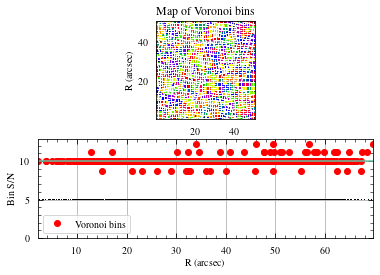

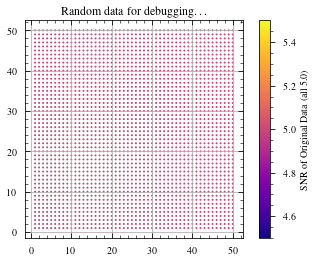

In [9]:
%matplotlib inline
gi_colour = -2.5 * np.log10(data_g_cut / data_i_cut)
gi_colour_err = calc_colour_err(data_g_cut, data_i_cut, noise_g_cut, noise_i_cut)
# 
# 20 x 20 re-binning
# 
gi_colour = block_reduce(gi_colour, block_size=(20, 20))
gi_colour_err = block_reduce(gi_colour_err, block_size=(20, 20))
# 
# Generate pixel coordinates (needed for vorbin)
# 
y_coords, x_coords = np.meshgrid(
    np.arange(gi_colour.shape[0]), np.arange(gi_colour.shape[1])
)
x_coords, y_coords = x_coords.T, y_coords.T
# is_good = np.isfinite(gi_colour_err)  # some pixels of the sigma maps are not finite
is_good = ~np.isnan(gi_colour_err)  # some pixels of the sigma maps are not finite
print("sum bad", np.sum(~is_good))
print(gi_colour_err.dtype)
# 
gi_snr = abs(np.ma.masked_where(~is_good, gi_colour / gi_colour_err))
print("gi_snr shape", gi_snr.shape)
# 
print("x coords good shape", x_coords[is_good].shape)
# print(np.sum(~np.isfinite(data_g_cut)))
# print(np.sum(~np.isfinite(data_i_cut)))
# print(np.sum(~np.isfinite(noise_g_cut)))
# print(np.sum(~np.isfinite(noise_i_cut)))
# print(np.sum(~np.isfinite(gi_colour_err)))
# ! LARGE IMAGE! Voronoi binning takes a long time. See method docstring
# 
# Explicitly setting array values to floats
# 
np.random.seed(42)
# Generate 1000 (total, not 1000 x 1000) random pixels
x_coords = np.arange(1,51).astype(int)
y_coords = np.arange(1,51).astype(int)
x_coords, y_coords = np.meshgrid(x_coords, y_coords)
print(x_coords.shape)
print(x_coords)
gi_colour = np.full(2500, 5.0)
gi_colour_err = np.full(2500, 1.0)

# 
binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(
    y_coords.flatten(),
    x_coords.flatten(),
    gi_colour.flatten(),
    gi_colour_err.flatten(),
    targetSN=10,  # ! anything above targetSN=8 will fail because it cannot bin to targetSN?!  
    pixelsize=None,
    cvt=False,
    quiet=True,
    wvt=False,
    sn_func=None,
)
# 
# 
# 
cmap = "plasma"
cmap = mpl.cm.get_cmap(cmap)
#
# fig, ax = plt.subplots(subplot_kw={"projection": wcs_i_cut})  # auto-sets origin="lower"
fig, ax = plt.subplots()
img = ax.scatter(x_coords.flatten(), y_coords.flatten(), c=(gi_colour/gi_colour_err), cmap=cmap, s=1)
# img = ax.imshow(gi_snr, cmap=cmap, origin="lower", vmax=100) 
# img = ax.imshow(gi_colour, cmap=cmap, vmin=0.5, vmax=1.6)
# img = ax.imshow(gi_colour_err, cmap=cmap, vmax=np.percentile(gi_colour_err[is_good], 15))
# utils.add_scalebar(ax, wcs_i_cut, vcc792_dist,
#                    scalebar_factor=2, label="2 kpc", color="w", loc="lower right")
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
# cbar.set_label("g-i Colour Index")
# cbar.set_label("SNR (g-i colour / error)")
cbar.set_label("SNR of Original Data (all 5.0)")
#
# Overplot CO contours from VERTICO data
#
# ax.contour(data_co, transform=ax.get_transform(WCS(header_co)), levels=0, colors='w')
# 
# ax.tick_params(which="both", direction="out")
# ax.set_xlabel("RA (J2000)")
# ax.set_ylabel("Dec (J2000)")
# ax.set_title("VCC 792 / NGC 4380")
ax.set_title("Random data for debugging\\ldots")
# ax.grid(False)
ax.set_aspect("equal")
# fig.savefig("imgs/raw_random_data.pdf")
plt.show()


In [25]:
plt.close("all")

(3107,) (3107,) (3107,) (3107,)
[-23.199969 -23.199947 -23.199911 -23.199902 -23.199959 -23.199969
 -23.200086 -22.399995 -22.400069 -22.400087]
Bin-accretion...
1  /  383
2  /  383
3  /  383
4  /  383
5  /  383
6  /  383
7  /  383
8  /  383
9  /  383
10  /  383
11  /  383
12  /  383
13  /  383
14  /  383
15  /  383
16  /  383
17  /  383
18  /  383
19  /  383
20  /  383
21  /  383
22  /  383
23  /  383
24  /  383
25  /  383
26  /  383
27  /  383
28  /  383
29  /  383
30  /  383
31  /  383
32  /  383
33  /  383
34  /  383
35  /  383
36  /  383
37  /  383
38  /  383
39  /  383
40  /  383
41  /  383
42  /  383
43  /  383
44  /  383
45  /  383
46  /  383
47  /  383
48  /  383
49  /  383
50  /  383
51  /  383
52  /  383
53  /  383
54  /  383
55  /  383
56  /  383
57  /  383
58  /  383
59  /  383
60  /  383
61  /  383
62  /  383
63  /  383
64  /  383
65  /  383
66  /  383
67  /  383
68  /  383
69  /  383
70  /  383
71  /  383
72  /  383
73  /  383
74  /  383
75  /  383
76  /  383
77  /  383


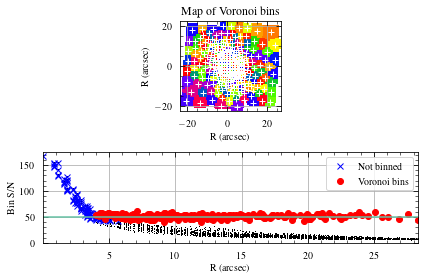

In [23]:
#!/usr/bin/env python

"""
Copyright (C) 2003-2014, Michele Cappellari
E-mail: michele.cappellari_at_physics.ox.ac.uk

    V1.0.0: Michele Cappellari, Vicenza, 13 February 2003
    V1.0.1: Use astro library routines to read and write files.
        MC, Leiden, 24 July 2003
    V2.0.0: Translated from IDL into Python. MC, London, 19 March 2014
    V2.0.1: Support both Python 2.6/2.7 and Python 3.x. MC, Oxford, 25 May 2014
    V2.0.2: Make files paths relative to this file, to run the example from
        any directory. MC, Oxford, 23 January 2017
    V2.0.3: Changed imports for vorbin as package. 
        Make file paths relative to the vorbin package to be able to run the
        example unchanged from any directory. MC, Oxford, 17 April 2018    
    V2.0.4: Dropped legacy Python 2.7 support. MC, Oxford, 10 May 2018

"""

from os import path
import numpy as np
import matplotlib.pyplot as plt

import vorbin
from vorbin.voronoi_2d_binning import voronoi_2d_binning

#-----------------------------------------------------------------------------

def voronoi_binning_example():
    """
    Usage example for the procedure VORONOI_2D_BINNING.

    It is assumed below that the file voronoi_2d_binning_example.txt
    resides in the current directory. Here columns 1-4 of the text file
    contain respectively the x, y coordinates of each SAURON lens
    and the corresponding Signal and Noise.

    """
    file_dir = path.dirname(path.realpath(vorbin.__file__))  # path of vorbin
    x, y, signal, noise = np.loadtxt(file_dir + '/example/voronoi_2d_binning_example_input.txt').T
    print(x.shape, y.shape, signal.shape, noise.shape)
    print(x[:10])
    targetSN = 50.0

    # Perform the actual computation. The vectors
    # (binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale)
    # are all generated in *output*
    #
    binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(
        x, y, signal, noise, targetSN, plot=1, quiet=0)

    # Save to a text file the initial coordinates of each pixel together
    # with the corresponding bin number computed by this procedure.
    # binNum uniquely specifies the bins and for this reason it is the only
    # number required for any subsequent calculation on the bins.
    #
    np.savetxt('voronoi_2d_binning_example_output.txt', np.column_stack([x, y, binNum]),
               fmt=b'%10.6f %10.6f %8i')

#-----------------------------------------------------------------------------

if __name__ == '__main__':

    voronoi_binning_example()
    plt.tight_layout()
    plt.pause(1)
